In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Unzipping dataset .zip file into 'dataset' folder

In [ ]:
cd /content

/content


In [ ]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins

!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Installing and importing required packages

In [ ]:
!pip install pyfeats

In [ ]:
!pip install mahotas

In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pathlib
import cv2
import random
import shutil
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import mahotas
import pyfeats
import warnings
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

warnings.filterwarnings('ignore')

## Getting names of all subfolders and storing them in variables for indexing and referencing purposes

In [ ]:
dataset_path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
folders = os.listdir(dataset_path)

dataset_index = {}

for folder in folders:
  split = folder.split("__")

  if len(split) < 2:
    continue

  leaf_type = split[0].replace(",", "")
  
  if leaf_type in dataset_index.keys():
    dataset_index[leaf_type].append(folder)
  else:
    dataset_index[leaf_type] = [folder]

dataset_index

{'Grape': ['Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Grape___Black_rot'],
 'Corn': ['Corn___Northern_Leaf_Blight',
  'Corn___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn___healthy',
  'Corn___Common_rust'],
 'Pepper_bell': ['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy'],
 'Tomato': ['Tomato___Target_Spot',
  'Tomato___Leaf_Mold',
  'Tomato___Early_blight',
  'Tomato___Tomato_mosaic_virus',
  'Tomato___healthy',
  'Tomato___Bacterial_spot',
  'Tomato___Late_blight',
  'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
  'Tomato___Spider_mites Two-spotted_spider_mite',
  'Tomato___Septoria_leaf_spot'],
 'Soybean': ['Soybean___healthy'],
 'Strawberry': ['Strawberry___healthy', 'Strawberry___Leaf_scorch'],
 'Blueberry': ['Blueberry___healthy'],
 'Apple': ['Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Apple___Black_rot',
  'Apple___Apple_scab'],
 'Peach': ['Peach___healthy', 'Peach___Bacterial_spot'],
 'Potato': ['Potat

In [ ]:
classes = []

for leaf_type in dataset_index.keys():
  classes = classes + dataset_index[leaf_type]

classes

['Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Grape___Black_rot',
 'Corn___Northern_Leaf_Blight',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___healthy',
 'Corn___Common_rust',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Tomato___Target_Spot',
 'Tomato___Leaf_Mold',
 'Tomato___Early_blight',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Late_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Septoria_leaf_spot',
 'Soybean___healthy',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Blueberry___healthy',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Apple___Black_rot',
 'Apple___Apple_scab',
 'Peach___healthy',
 'Peach___Bacterial_spot',
 'Potato___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Raspberry___healthy',
 'Or

## Creating curated dataset for classification for a specific leaf type

In [ ]:
source_dataset = '/content/dataset/Plant_leave_diseases_dataset_with_augmentation/'

folders = os.listdir(source_dataset)
healthy_folders = [x for x in folders if 'healthy' in x]
diseased_folders = [x for x in folders if 'healthy' not in x]
diseased_folders.remove('Background_without_leaves')

healthy_source_paths = []
healthy_destination_paths = []
diseased_source_paths = []
diseased_destination_paths = [] 

healthy_destination_folder = '/content/curated_dataset/healthy/'
diseased_destination_folder = '/content/curated_dataset/diseased/'

In [ ]:
for folder in tqdm(healthy_folders):
  paths = os.listdir(source_dataset+folder+"/")
  full_paths = [source_dataset+folder+"/"+x for x in paths]
  for full_path in full_paths:
    healthy_source_paths.append(full_path)

100%|██████████| 12/12 [00:00<00:00, 364.75it/s]


In [ ]:
for folder in tqdm(diseased_folders):
  paths = os.listdir(source_dataset+folder+"/")
  full_paths = [source_dataset+folder+"/"+x for x in paths]
  for full_path in full_paths:
    diseased_source_paths.append(full_path)

100%|██████████| 26/26 [00:00<00:00, 630.87it/s]


In [ ]:
healthy_count = len(healthy_source_paths)
diseased_count = len(diseased_source_paths)

print("Number of healthy leaf images : {}".format(healthy_count))
print("Number of diseased leaf images : {}".format(diseased_count))

Number of healthy leaf images : 18468
Number of diseased leaf images : 41875


In [ ]:
healthy_destination_paths = [healthy_destination_folder+str(i)+'.jpg' for i in range(1,len(healthy_source_paths)+1)]
diseased_destination_paths = [diseased_destination_folder+str(i)+'.jpg' for i in range(1,len(diseased_source_paths)+1)]

In [ ]:
assert healthy_count == len(healthy_destination_paths)
assert diseased_count == len(diseased_destination_paths)

In [ ]:
base_path = '/content/'
curated_dataset = 'curated_dataset/'
classes = ['healthy', 'diseased']

for cls in classes:
  path = base_path + curated_dataset + cls + '/'
  p = pathlib.Path(path)
  p.mkdir(parents=True, exist_ok=True)

In [ ]:
for i in tqdm(range(len(healthy_source_paths))):
  shutil.copyfile(healthy_source_paths[i], healthy_destination_paths[i])

100%|██████████| 18468/18468 [00:02<00:00, 6903.49it/s]


In [ ]:
for i in tqdm(range(len(diseased_source_paths))):
  shutil.copyfile(diseased_source_paths[i], diseased_destination_paths[i])

100%|██████████| 41875/41875 [00:09<00:00, 4459.94it/s]


## Data Pre-processing

In [ ]:
images_per_class = 10000
fixed_size = tuple((500, 500))
mask = np.ones(fixed_size)
bins = 8

In [ ]:
def bgr2rgb(image):
  rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return rgb_img

def rgb2hsv(rgb_img):
  hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
  return hsv_img

def img_segmentation(rgb_img,hsv_img):
  l_g = np.array([25,0,20])
  u_g = np.array([100,255,255])
  h_mask = cv2.inRange(hsv_img, l_g, u_g)
  result = cv2.bitwise_and(rgb_img,rgb_img, mask=h_mask)
  
  l_b = np.array([10,0,10])
  u_b = np.array([30,255,255])
  d_mask = cv2.inRange(hsv_img, l_b, u_b)
  d_result = cv2.bitwise_and(rgb_img, rgb_img, mask=d_mask)
  
  final_mask = h_mask + d_mask
  final_result = cv2.bitwise_and(rgb_img, rgb_img, mask=final_mask)
  
  return final_result

def zernikes_moments_features(grayscale_image):
  zernikes_moments_features, labels = pyfeats.zernikes_moments(grayscale_image, radius=9)
  return zernikes_moments_features

def haralick_features(grayscale_image):
  haralick = mahotas.features.haralick(grayscale_image).mean(axis=0)
  return haralick

def histogram_features(image, mask=None):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hist  = cv2.calcHist([hsv_image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
  cv2.normalize(hist, hist)
  return hist.flatten()

## Creating curated dataset for classification for a specific leaf type

In [ ]:
train_path = base_path + curated_dataset

In [ ]:
global_features = []
labels          = []

In [ ]:
for cls in classes:
  current_label = cls
  
  image_paths = os.listdir(train_path + cls)
  sample_set = list(range(1,len(image_paths)+1))
  sampled_image_numbers = random.sample(sample_set, images_per_class)
  sampled_image_paths = [str(sampled_image_number) + '.jpg' for sampled_image_number in sampled_image_numbers]
  print(cls)

  for idx in tqdm(range(len(sampled_image_paths))):
    image_path = sampled_image_paths[idx]
    image_bgr = cv2.imread(train_path + cls + '/' + image_path)
    image_bgr = cv2.resize(image_bgr, fixed_size)

    image_rgb = bgr2rgb(image_bgr)
    image_hsv = rgb2hsv(image_rgb)
    image_segmented = img_segmentation(image_rgb,image_hsv)
    grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

    hist_features = histogram_features(image_segmented)
    zernikes_features = zernikes_moments_features(grayscale_image)
    har_features = haralick_features(grayscale_image)
    
    global_feature = np.hstack([zernikes_features,hist_features,har_features])

    labels.append(current_label)
    global_features.append(global_feature)

healthy


100%|██████████| 10000/10000 [10:57<00:00, 15.22it/s]


diseased


100%|██████████| 10000/10000 [10:52<00:00, 15.32it/s]


## Save Global Features and Labels in Pickle file

In [ ]:
properties =  'imsize='+str(fixed_size[0]) +'x'+str(fixed_size[0]) + \
              '_'+'perclsimgs=' + str(images_per_class) + \
              '_clsnum=' + str(len(classes))

In [ ]:
global_features_filename = 'globalfeatures' + '_' + properties + '.pkl'
labels_filename = 'labels' + '_' + properties + '.pkl'

print('Global Features save filename: {}'.format(global_features_filename))
print('Labels save filename: {}'.format(labels_filename))

Global Features save filename: globalfeatures_imsize=500x500_perclsimgs=10000_clsnum=2.pkl
Labels save filename: globalfeatures_imsize=500x500_perclsimgs=10000_clsnum=2.pkl


In [ ]:
with open(global_features_filename, 'wb') as fp:
  pickle.dump(global_features, fp)

with open(labels_filename, 'wb') as fp:
  pickle.dump(labels, fp)

Code for saving onto Google Drive

In [ ]:
shutil.copy(global_features_filename,'/content/drive/MyDrive/5554')
shutil.copy(labels_filename,'/content/drive/MyDrive/5554')

'/content/drive/MyDrive/5554/labels_imsize=500x500_perclsimgs=10000_clsnum=2.pkl'

Code for loading global features and labels


In [ ]:
saved_gf_path = '/content/drive/MyDrive/5554/globalfeatures_imsize=500x500_perclsimgs=10000_clsnum=2.pkl'
saved_label_path = '/content/drive/MyDrive/5554/labels_imsize=500x500_perclsimgs=10000_clsnum=2.pkl'

with open(saved_gf_path, 'rb') as file:
  global_features = pickle.load(file)

with open(saved_label_path, 'rb') as file:
  labels = pickle.load(file)

Lengths of Vectors

In [ ]:
print('Feature Vector shape: {}'.format(np.array(global_features).shape))
print('Training Labels shape: {}'.format(np.array(labels).shape))

Feature Vector shape: (20000, 550)
Training Labels shape: (20000,)


## Standardizing input data and Training XGBoost

In [ ]:
label_names = np.unique(labels)
labelencoder = LabelEncoder()
labels_enc = labelencoder.fit_transform(labels)

In [ ]:
print('Encoded Labels: {}'.format(labels_enc))
print('Encoded Labels shape: {}'.format(labels_enc.shape))

Encoded Labels: [1 1 1 ... 0 0 0]
Encoded Labels shape: (20000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(global_features), labels_enc, test_size=.3)

In [ ]:
print('Train Shape: {}'.format(X_train.shape))
print('Test Shape: {}'.format(X_test.shape))

Train Shape: (14000, 550)
Test Shape: (6000, 550)


In [ ]:
xgb_clf = XGBClassifier(max_depth=3, verbosity=1)

In [ ]:
xgb_clf.fit(X_train, y_train)

XGBClassifier()

In [ ]:
predictions = xgb_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test,predictions)
print('Accuracy: {}'.format(acc))

Accuracy: 0.9538333333333333


## Save XGBoost model


In [ ]:
model_filename = 'xgboost_' + properties + '_tstacc=%.2f'% acc + '.pkl'
print('Filename for saving xgboost model: {}'.format(model_filename))

Filename for saving xgboost model: xgboost_imsize=500x500_perclsimgs=10000_clsnum=2_tstacc=0.95.pkl


In [ ]:
# save xgboost model

with open(model_filename, 'wb') as fp:
  pickle.dump(xgb_clf, fp)

In [ ]:
shutil.copy(model_filename,'/content/drive/MyDrive/5554')

'/content/drive/MyDrive/5554/xgboost_imsize=500x500_perclsimgs=10000_clsnum=2_tstacc=0.95.pkl'

## Load XGBoost model for evaluation on data

In [ ]:
with open(model_filename, 'rb') as fp:
  testclf = pickle.load(fp)

In [ ]:
def random_prediction():
  dataset_path = '/content/dataset/Plant_leave_diseases_dataset_with_augmentation/'
  folder_list = os.listdir(dataset_path)
  sample_folder_name = random.choice(folder_list)
  sample_folder_path = dataset_path + sample_folder_name + "/"

  sample_image_name = random.choice(os.listdir(sample_folder_path))
  sample_image_path = sample_folder_path + sample_image_name

  image_bgr = cv2.imread(sample_image_path)
  image_rgb = bgr2rgb(image_bgr)
  image_hsv = rgb2hsv(image_rgb)
  image_segmented = img_segmentation(image_rgb,image_hsv)
  grayscale_image = cv2.cvtColor(image_segmented, cv2.COLOR_RGB2GRAY)

  hist_features = histogram_features(image_segmented)
  zernikes_features = zernikes_moments_features(grayscale_image)
  har_features = haralick_features(grayscale_image)
  
  global_feature = np.hstack([zernikes_features,hist_features,har_features])

  plt.title(sample_folder_name + '/' + sample_image_name)
  plt.imshow(image_rgb)
  plt.show()

  predicted_index = testclf.predict(np.reshape(global_feature,(1,len(global_feature))))
  
  prediction = np.unique(classes)[predicted_index]
  print("Prediction : {}".format(prediction))

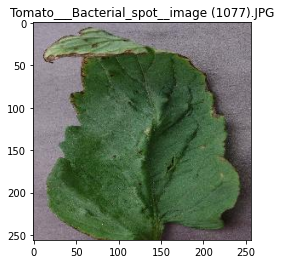

Prediction : ['diseased']


In [ ]:
random_prediction()